## Goals to complete:
- Build raw neural network
- Use Keras Resnet50

## Steps:
1. **Write python file to seperate images**
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n
2. **Visualize data**
3. **Create image generator**
4. **Load data**
5. **Create model**
6. **Fit model**
7. **Plot history**
8. **Check overfitting**
9. **Get result**

## Notes:
- (Accuracy -- Val_accuracy) and (Loss -- Val_loss): Check overfitting
- MaxPooling2D: Reduce image size

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Visualize data

(374, 500, 3)


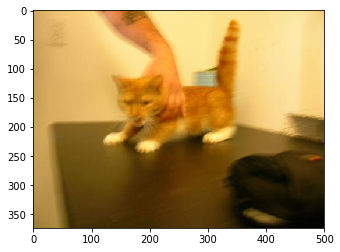

In [2]:
cat0 = cv2.imread('train/cat/cat.0.jpg')
cat0 = cv2.cvtColor(cat0, cv2.COLOR_BGR2RGB)
print(cat0.shape)

plt.imshow(cat0)

(375, 499, 3)


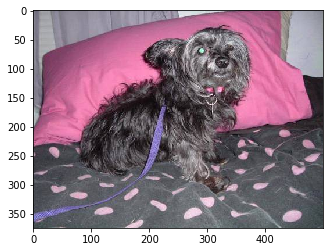

In [3]:
dog0 = cv2.imread('train/dog/dog.0.jpg')
dog0 = cv2.cvtColor(dog0, cv2.COLOR_BGR2RGB)
print(dog0.shape)

plt.imshow(dog0)

### Create ImageDataGenerator

In [4]:
image_gen = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1/255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               validation_split=0.2,
                               fill_mode='nearest')

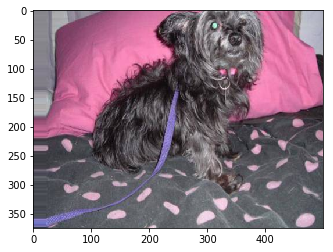

In [5]:
plt.imshow(image_gen.random_transform(dog0))

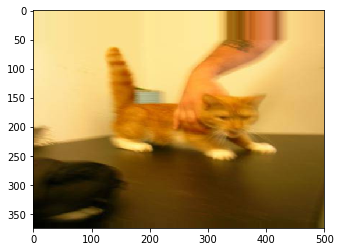

In [6]:
plt.imshow(image_gen.random_transform(cat0))

### Load data

In [7]:
directory = 'train'
batch_size = 16
image_shape = (127, 127, 3)

train_data = image_gen.flow_from_directory(directory,
                                          target_size=image_shape[:2],
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          subset='training')

test_data = image_gen.flow_from_directory(directory,
                                          target_size=image_shape[:2],
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          subset='validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


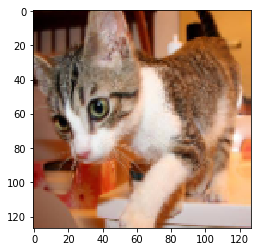

In [8]:
plt.imshow(train_data[0][0][4])

In [9]:
print(train_data.samples, test_data.samples)

20000 5000


### Create model

In [ ]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), input_shape=image_shape),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=64, kernel_size=(3,3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=64, kernel_size=(3,3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=64, kernel_size=(3,3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=64, kernel_size=(3,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

### Fit model

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop]

In [14]:
results = model.fit_generator(train_data,
                              epochs=25,
                              validation_data=test_data,
                              validation_steps=test_data.samples//batch_size,
                              steps_per_epoch=train_data.samples//batch_size,
                              callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps
Epoch 1/25
1250/1250 [==============================] - 117s 94ms/step - loss: 0.6665 - accuracy: 0.5992 - val_loss: 0.6005 - val_accuracy: 0.6771
Epoch 2/25
1250/1250 [==============================] - 99s 79ms/step - loss: 0.5787 - accuracy: 0.7060 - val_loss: 0.5227 - val_accuracy: 0.7328
Epoch 3/25
1250/1250 [==============================] - 97s 78ms/step - loss: 0.4907 - accuracy: 0.7702 - val_loss: 0.5866 - val_accuracy: 0.7348
Epoch 4/25
1250/1250 [==============================] - 98s 78ms/step - loss: 0.4438 - accuracy: 0.7950 - val_loss: 0.4051 - val_accuracy: 0.8103
Epoch 5/25
1250/1250 [==============================] - 99s 79ms/step - loss: 0.4208 - accuracy: 0.8105 - val_loss: 0.4043 - val_accuracy: 0.8143
Epoch 6/25
1250/1250 [==============================] - 97s 78ms/step - loss: 0.3964 - accuracy: 0

In [15]:
model.save('model.h5')

### Plot history

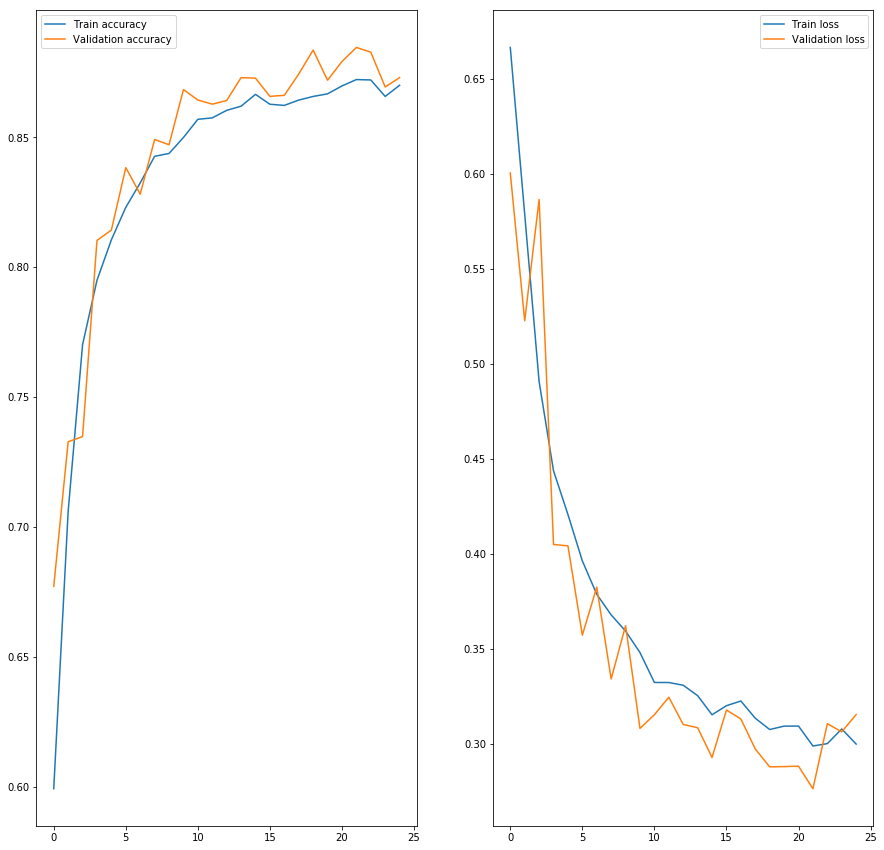

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].plot(results.history['accuracy'], label='Train accuracy')
ax[0].plot(results.history['val_accuracy'], label='Validation accuracy')
ax[0].legend(['Train accuracy', 'Validation accuracy'])

ax[1].plot(results.history['loss'], label='Train loss')
ax[1].plot(results.history['val_loss'], label='Validation loss')
ax[1].legend(['Train loss', 'Validation loss'])

plt.show()

### Get result

In [19]:
test_filenames = os.listdir('test/test')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [20]:
test_gen = ImageDataGenerator(rescale=1./255)

test_set = test_gen.flow_from_dataframe(
    test_df,
    'test/test',
    target_size=image_shape[:2],
    batch_size=batch_size,
    x_col='filename',
    y_col=None,
    class_mode=None,
    shuffle=False
)

Found 12500 validated image filenames.


In [21]:
predictions = model.predict_generator(test_set)

Instructions for updating:
Please use Model.predict, which supports generators.


In [22]:
test_df['label'] = np.round(predictions).astype(int)

In [23]:
test_df['id'] = test_df['filename'].str.split('.').str[0]
test_df = test_df.drop('filename', axis=1)

In [24]:
test_df.to_csv(path_or_buf='result.csv', index=False)